In [1]:
import dateutil
import matplotlib.pyplot as plt
import pandas
import re
import requests
import seaborn

from collections import Counter
from datetime import datetime
from user_agent import generate_user_agent
from bs4 import BeautifulSoup

In [2]:
keyword = 'Django'
area = 2  # 1 - MSK, 2 - SPB
salary = 120 * 1000  # RUR

In [3]:
BASE_URL = 'https://api.hh.ru'

In [4]:
params = dict(
    order_by='salary_desc',
    text=keyword,
    area=area,
    period=30, # days
    per_page=100,
    no_magic='false',  # disable magic
    vacancy_search_fields='description',  # available: name, description, company_name
)
response = requests.get(
    BASE_URL + '/vacancies',
    headers={'User-Agent': generate_user_agent()},
    params=params,
)
response

<Response [200]>

## Main info

In [5]:
items = response.json()['items']
vacancies = []
for item in items:
    vacancies.append(dict(
        id=item['id'],
        name=item['name'],
        salary_from=item['salary']['from'] if item['salary'] else None,
        salary_to=item['salary']['to'] if item['salary'] else None,
        created=item['published_at'],
        company=item['employer']['name'],
        company_id=item['employer']['id'],
    ))

vacancies = pandas.DataFrame(
    vacancies,
    columns=['id', 'name', 'salary_from', 'salary_to', 'created', 'company_id', 'company'],
)

In [6]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company
0,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-03T13:00:40+0300,1818108,IBIT
1,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-14T16:02:17+0300,1738507,Soshace
2,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09T18:34:04+0300,9281,JetBrains
3,25195178,Ведущий python разработчик,170000.0,220000.0,2018-04-12T11:57:24+0300,2068941,Cindicator
4,24927220,Senior Web Developer (Python/Django),2000.0,3000.0,2018-03-20T04:22:36+0300,3192431,Investex Ltd


In [7]:
# convert ISO string to datetime
vacancies['created'] = vacancies['created'].apply(lambda x: dateutil.parser.parse(x))

In [8]:
# extract weekday and publish time from vacancies
vacancies['weekday'] = vacancies['created'].apply(lambda x: x.weekday() + 1)
vacancies['hour'] = vacancies['created'].apply(lambda x: x.hour)

In [9]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company,weekday,hour
0,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-03 13:00:40+03:00,1818108,IBIT,2,13
1,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-14 16:02:17+03:00,1738507,Soshace,6,16
2,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09 18:34:04+03:00,9281,JetBrains,1,18
3,25195178,Ведущий python разработчик,170000.0,220000.0,2018-04-12 11:57:24+03:00,2068941,Cindicator,4,11
4,24927220,Senior Web Developer (Python/Django),2000.0,3000.0,2018-03-20 04:22:36+03:00,3192431,Investex Ltd,2,4


In [10]:
vacancies.describe()

,salary_from,salary_to,weekday,hour
count,31.000000,19.000000,61.000000,61.000000
mean,92806.451613,129000.000000,3.409836,14.065574
std,55269.291869,79499.825297,1.883056,3.991110
min,1000.000000,3000.000000,1.000000,1.000000
25%,60000.000000,72500.000000,2.000000,11.000000
50%,95000.000000,120000.000000,4.000000,14.000000
75%,130000.000000,200000.000000,5.000000,17.000000
max,200000.000000,300000.000000,7.000000,22.000000


In [11]:
%matplotlib inline

Let's find hardest HR's days and hours

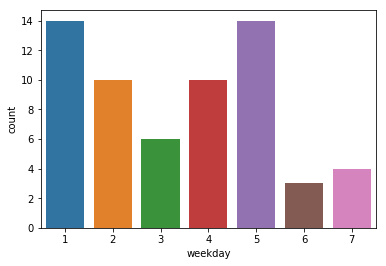

In [12]:
seaborn.countplot(vacancies.weekday)

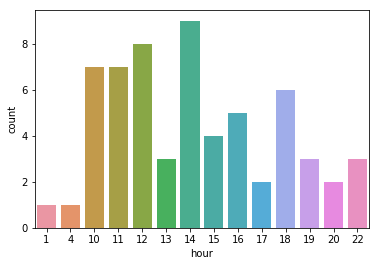

In [13]:
seaborn.countplot(vacancies.hour)

Bad companies that work in night or holydays:

In [47]:
blacklist = vacancies[(vacancies.hour >= 20) | (vacancies.hour < 10) | (vacancies.weekday > 5)]
blacklist.sort_values('company')[['company', 'weekday', 'hour']]

,company,weekday,hour
4,Investex Ltd,2,4
20,Muzis,6,11
1,Soshace,6,16
41,Wargaming,7,12
17,i-FREE,4,20
30,АйТи-Солюшн,4,1
29,АппВелокс,6,22
6,Аэропоиск,2,22
27,ВЕБИМ.РУ,5,22
47,Доктор Веб,1,20


Let's analize salaries!

In [118]:
sfrom = vacancies[vacancies.salary_from > 10000].salary_from.min()
sto = vacancies.salary_to.mean()
sfrom, sto

(16000.0, 129000.0)

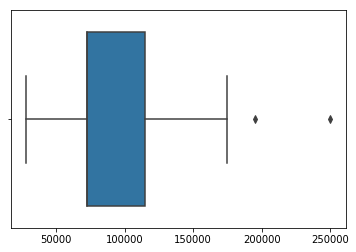

In [119]:
def avg_salary(row):
    if pandas.isnull(row.salary_from) or row.salary_from < 10000:
        f = sfrom
    else:
        f = row.salary_from
    if pandas.isnull(row.salary_to) or row.salary_to < 10000:
        t = sto
    else:
        t = row.salary_to
    return float(f + t) / 2

seaborn.boxplot(vacancies.apply(avg_salary, axis=1))

## Keywords

In [14]:
rex = re.compile(r'[A-Za-z ]{3,}')

In [15]:
keywords = []
for vid in vacancies['id']:
    response = requests.get(
        BASE_URL + '/vacancies/{vacancy_id}'.format(vacancy_id=vid),
        headers={'User-Agent': generate_user_agent()},
    )
    text = response.json()['description']
    text = BeautifulSoup(text, 'html.parser').get_text()
    keywords.extend(rex.findall(text))

In [16]:
keywords = [kw.lower().strip() for kw in keywords]
keywords = [kw for kw in keywords if kw]

In [17]:
keywords_dataframe = pandas.DataFrame(Counter(keywords).most_common(40), columns=['keyword', 'count'])

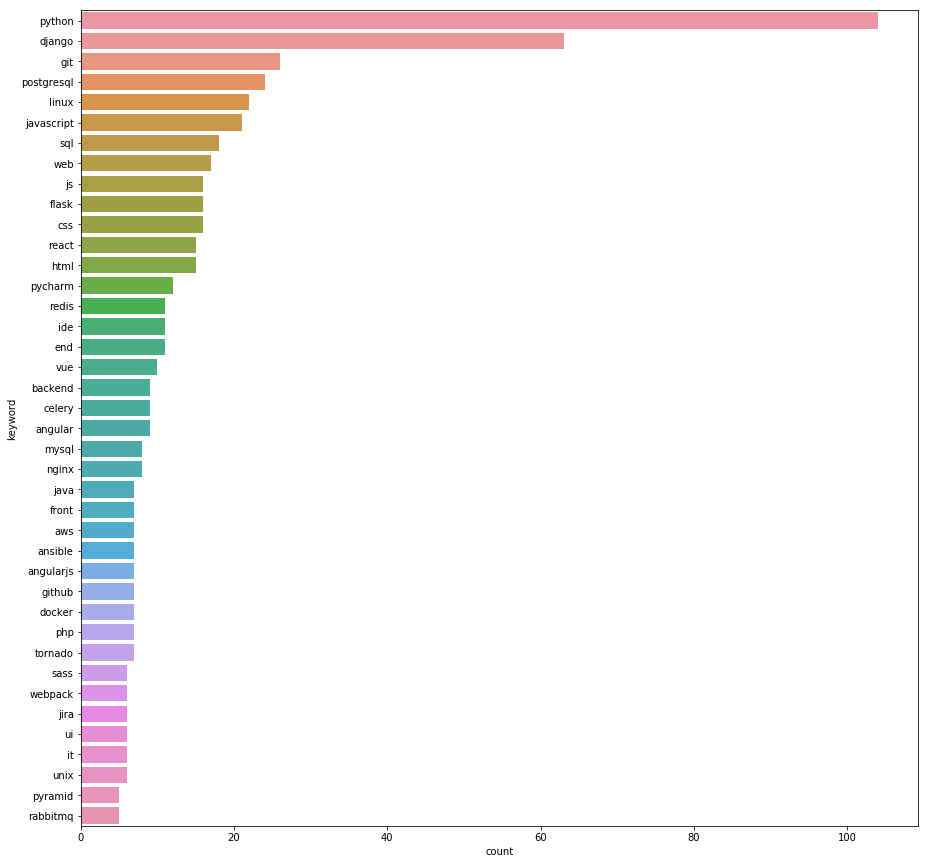

In [18]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)

seaborn.barplot(data=keywords_dataframe, x='count', y='keyword', ax=ax)

## Company info

In [48]:
areas = []
cids = set()
for cid, cname in zip(vacancies.company_id, vacancies.company):
    # only unique requests
    if cid in cids:
        continue
    cids.add(cid)

    # retrieve
    params = dict(
        employer_id=cid,
        area=area,
        period=30,
        per_page=0,
        clusters='true',
    )
    response = requests.get(
        BASE_URL + '/vacancies',
        headers={'User-Agent': generate_user_agent()},
        params=params,
    )

    # analize clusters
    for cluster in response.json()['clusters']:
        if cluster['id'] == 'professional_area':
            good = total = 0
            for item in cluster['items']:
                if item['name'] == 'Информационные технологии, интернет, телеком':
                    good += item['count']
                total += item['count']
            areas.append(dict(
                company=cname,
                company_id=cid,
                count=total,
                rate=good / total
            ))

In [140]:
areas_dataframe = pandas.DataFrame(areas, columns=['company', 'company_id', 'count', 'rate'])

Mostly tech companies:

In [141]:
areas_dataframe = areas_dataframe.sort_values(by='rate', ascending=False)
areas_dataframe = areas_dataframe.reset_index()
areas_dataframe = areas_dataframe.drop('index', 1)
areas_dataframe[areas_dataframe.rate >= .5]

,company,company_id,count,rate
0,Luxoft,1304,22,0.954545
1,JetBrains,9281,68,0.882353
2,DataArt,69961,16,0.875000
3,First Line Software,638130,22,0.863636
4,НИИ МАСШТАБ,841097,21,0.809524
5,БиАйЭй-Технолоджиз,2565797,51,0.803922
6,TradingView,1235972,12,0.666667
7,SEMrush,789662,63,0.650794
8,Cindicator,2068941,14,0.642857
9,ЦИАН ГРУПП,1429999,11,0.636364


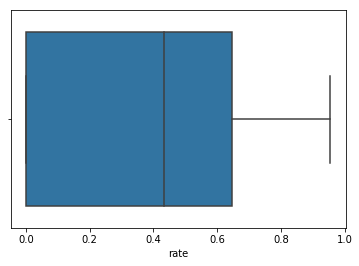

In [142]:
seaborn.boxplot(areas_dataframe.rate)

# One company info

In [188]:
cid = areas_dataframe.company_id[12]

In [189]:
areas_dataframe[areas_dataframe.company_id == cid]

,company,company_id,count,rate
12,SMART HR,2389305,17,0.529412


In [190]:
# retrieve
params = dict(
    employer_id=cid,
    area=area,
    period=30, # days
    per_page=100,
)
response = requests.get(
    BASE_URL + '/vacancies',
    headers={'User-Agent': generate_user_agent()},
    params=params,
)
response

<Response [200]>

In [191]:
company_vacancies = []
for item in response.json()['items']:
    company_vacancies.append(dict(
        id=item['id'],
        name=item['name'],
        salary_from=item['salary']['from'] if item['salary'] else None,
        salary_to=item['salary']['to'] if item['salary'] else None,
        created=dateutil.parser.parse(item['published_at']),
    ))

company_vacancies = pandas.DataFrame(
    company_vacancies,
    columns=['id', 'name', 'salary_from', 'salary_to', 'created'],
)

In [192]:
company_vacancies.head(10)

,id,name,salary_from,salary_to,created
0,25183685,Специалист call-центра со знанием казахского я...,28000.0,35000.0,2018-04-13 11:20:09+03:00
1,25282847,Системный аналитик,NaN,NaN,2018-04-13 10:53:54+03:00
2,25376228,Интернет-маркетолог,NaN,NaN,2018-04-13 10:16:29+03:00
3,24967524,Интернет-маркетолог / таргетолог ( blockchain),NaN,NaN,2018-04-12 15:44:23+03:00
4,25032282,Программист Python (blockchain),NaN,NaN,2018-04-12 15:44:23+03:00
5,25063256,Project manager/Менеджер проекта (blockchain/б...,NaN,NaN,2018-04-12 10:06:52+03:00
6,24518228,Java-программист,60000.0,80000.0,2018-04-10 14:42:03+03:00
7,25273043,Ведущий специалист отдела финансового мониторинга,50000.0,NaN,2018-04-10 12:38:19+03:00
8,25316928,Ведущий системный аналитик,70000.0,80000.0,2018-04-10 11:42:22+03:00
9,24021515,Программист Python,100000.0,200000.0,2018-04-09 18:16:24+03:00


In [193]:
company_vacancies.count()

id             12
name           12
salary_from     6
salary_to       5
created        12
dtype: int64

In [194]:
company_vacancies['weekday'] = company_vacancies['created'].apply(lambda x: x.weekday() + 1)
company_vacancies['hour'] = company_vacancies['created'].apply(lambda x: x.hour)

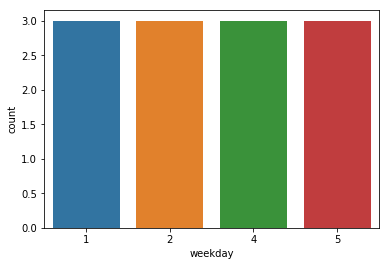

In [195]:
seaborn.countplot(company_vacancies.weekday)

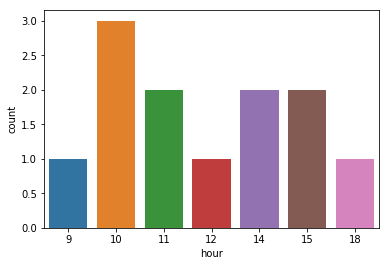

In [196]:
seaborn.countplot(company_vacancies.hour)

In [197]:
sfrom = company_vacancies[company_vacancies.salary_from > 10000].salary_from.min()
sto = company_vacancies.salary_to.min()

sfrom, sto

(28000.0, 35000.0)

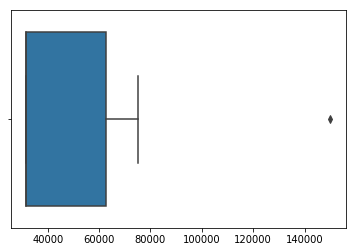

In [198]:
def avg_salary(row):
    if pandas.isnull(row.salary_from) or row.salary_from < 10000:
        f = sfrom
    else:
        f = row.salary_from
    if pandas.isnull(row.salary_to) or row.salary_to < 10000:
        t = sto
    else:
        t = row.salary_to
    return float(f + t) / 2

seaborn.boxplot(company_vacancies.apply(avg_salary, axis=1))